# Objective

This notebook explains and demonstrates the circularity calculation process.

# Overview of Steps

### Steps to get images
_Manual_
1. Segment neck and handles away from body in CC
2. Image captures at desired orientations in CC

### Steps to get circularities from images
_Automated, and demonstrated in this notebook_
1. Load 2D pixel array, convert to grayscale
2. Gaussian blur the image
3. Find the Otsu threshold of all pixels' intensity values
4. Binarize the image using otsu threshold
5. Flood all holes in the shape
6. Calculate perimeter of shape
7. Calculate area of shape
8. Circularity = 4\*pi\*area / perimeter^2

# Notes

Since last we looked at circularity, OpenCV methods have been replaced with scikit-image methods.

The backend code used by this notebook lives in a Python file (`circularity_util.py`). This notebook imports methods from that file, which contains ~200 lines of code that would otherwise clutter this notebook.

In [1]:
import circularity_util
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from skimage.io import imread
from skimage.filters import gaussian, threshold_otsu
from math import pi
from itertools import chain
%load_ext autoreload
%autoreload 2

# Step 1: Load 2D pixel array, convert to grayscale

Using Yassiada amphora 84-3 to demonstrate.

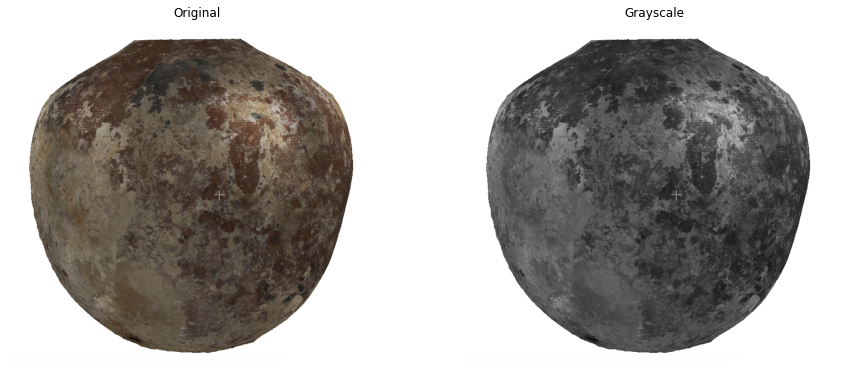

In [2]:
im_path = './vert/vert_84-3_0.png'
im = imread(im_path)
im_gray = imread(im_path, as_gray=True)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(im)
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(im_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Grayscale')
plt.show()

# Step 2: Apply a Gaussian blur to the image.

The visual distance is subtle but on the pixel level, this really helps to smooth out the edges.

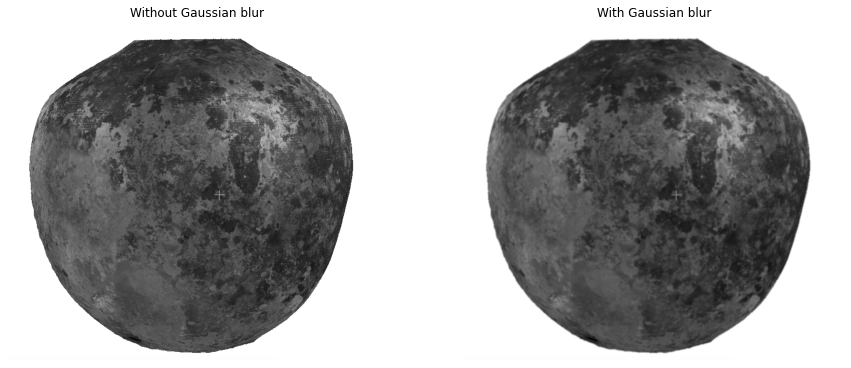

In [3]:
im_gauss = gaussian(im_gray)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(im_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Without Gaussian blur')
ax[1].imshow(im_gauss, cmap='gray')
ax[1].axis('off')
ax[1].set_title('With Gaussian blur')
plt.show()

# Step 3: Find the Otsu threshold of pixel intensity values

In [4]:
otsu_threshold = threshold_otsu(im_gauss)
print(otsu_threshold)

0.6531418502899189


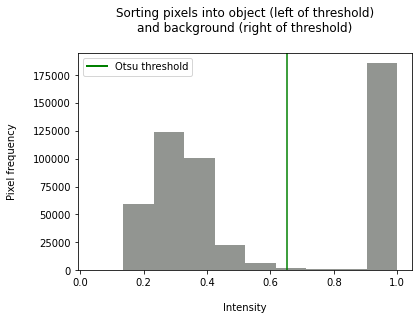

In [5]:
intensities = list(chain.from_iterable(im_gauss))
plt.hist(intensities, color='xkcd:gray')
plt.axvline(otsu_threshold, color='g')
otsu_line = Line2D([0], [0], color='g', linewidth=2, linestyle='-')
plt.legend([otsu_line], ['Otsu threshold'], loc='upper left')
plt.xlabel('\nIntensity')
plt.ylabel('Pixel frequency\n')
plt.title('Sorting pixels into object (left of threshold)\nand background (right of threshold)\n')
plt.show()

# Step 4: Binarize the image using the Otsu threshold

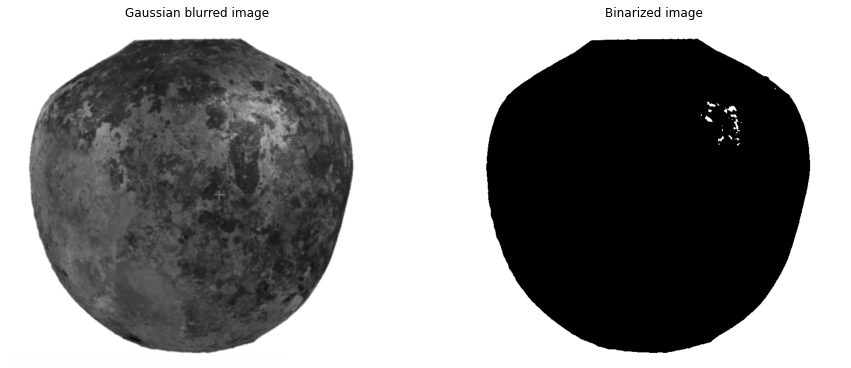

In [6]:
bin_im = circularity_util.bin_from_gauss_and_thresh(im_gauss, otsu_threshold)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(im_gauss, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Gaussian blurred image')
ax[1].imshow(bin_im, cmap='gray_r')
ax[1].axis('off')
ax[1].set_title('Binarized image')
plt.show()

# Step 5: Flood all holes in the shape

Identify the edges of the shape and flood every pixel inside the shape.

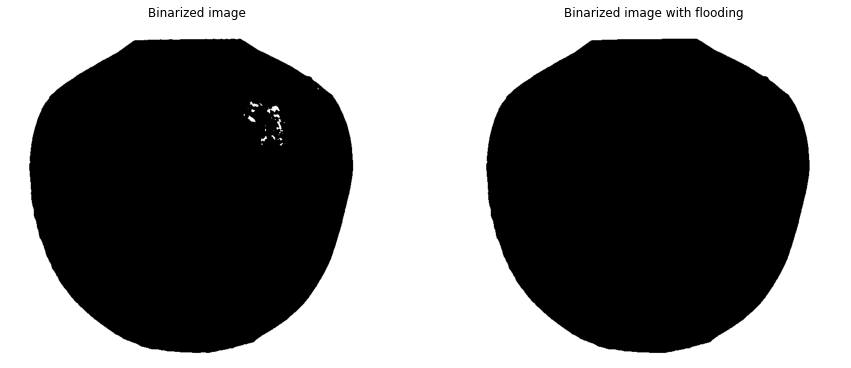

In [7]:
xmin, xmax, ymin, ymax = circularity_util.get_shape_bounds(bin_im)
im_flood = circularity_util.flood(bin_im, ymin, ymax)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(bin_im, cmap='gray_r')
ax[0].axis('off')
ax[0].set_title('Binarized image')
ax[1].imshow(im_flood, cmap='gray_r')
ax[1].axis('off')
ax[1].set_title('Binarized image with flooding')
plt.show()

# Step 6: Calculate the perimeter of the shape

Trace the edge of the shape.

In [8]:
perimeter = circularity_util.get_perimeter(im_flood)
perimeter

2024.4058304089035

# Step 7: Calculate the area of the shape

Aggregate the pixel area of the shape.

In [9]:
area = circularity_util.get_area(im_flood)
print(area)

315966.0


# Step 8: Circularity = 4\*pi\*Area / Perimeter^2

For reference, an ideal circle with diameter equal to the amphora's max width is shown on top of the amphora's flooded silhouette.

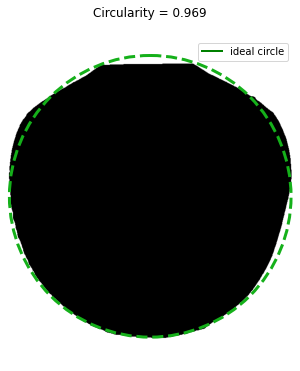

In [10]:
circularity = 4 * np.pi * area/ perimeter**2

fig, axes = plt.subplots(figsize=(6,6))
axes.set_title('Circularity = %s\n' % round(circularity, 3))    
axes.imshow(im_flood, cmap='gray_r')
axes.set_xlim(xmin-5, xmax+5)
axes.set_ylim(ymin-60, ymax+60)
axes.set_ylim(axes.get_ylim()[::-1])
axes.axis('off')

center = ((xmax-xmin)/2 + xmin, (ymax-ymin)/2 + ymin - 10)
radius = (xmax-xmin)/2
circle = plt.Circle(center, radius, color='xkcd:green', fill=False, lw=3, linestyle='--')
axes.add_patch(circle)
circle = Line2D([0], [0], color='xkcd:green', lw=3, linestyle='--')
plt.legend([otsu_line], ['ideal circle'], loc='upper right')
plt.show()

# Other shapes

Calculate circularity of other shapes, for context.

## Reference Circle

Silhouette of an ideal sphere

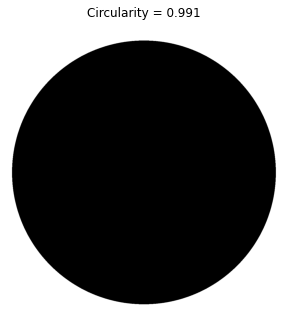

In [11]:
bin_im = circularity_util.get_bin_im('circle_ref.png')
circularity = circularity_util.get_circularity(bin_im)

fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('Circularity = %s\n' % round(circularity, 3))
axes.imshow(bin_im, cmap='gray_r')
axes.set_ylim(axes.get_ylim()[::-1])
axes.axis('off')
plt.show()

0.991 =/= 1 because perimeter and area calculation accuracy is limited by pixel granularity.

## Square

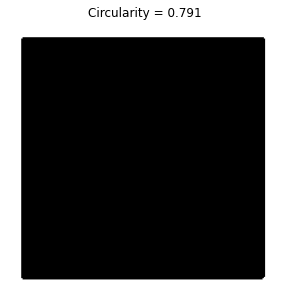

In [12]:
bin_im = circularity_util.get_bin_im('square.png')
circularity = circularity_util.get_circularity(bin_im)

fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('Circularity = %s' % round(circularity, 3))
axes.imshow(bin_im, cmap='gray_r')
axes.set_ylim(axes.get_ylim()[::-1])
axes.axis('off')
plt.show()

## Rectangle

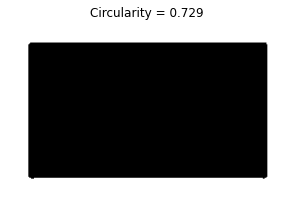

In [13]:
bin_im = circularity_util.get_bin_im('rectangle.png')
circularity = circularity_util.get_circularity(bin_im)

fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('Circularity = %s' % round(circularity, 3))
axes.imshow(bin_im, cmap='gray_r')
axes.set_ylim(axes.get_ylim()[::-1])
axes.axis('off')
plt.show()

## Random snip of a handle fragment

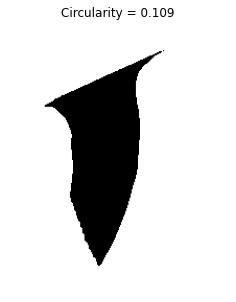

In [14]:
bin_im = circularity_util.get_bin_im('snip.png')
circularity = circularity_util.get_circularity(bin_im)

fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('Circularity = %s' % round(circularity, 3))
axes.imshow(bin_im, cmap='gray_r')
axes.set_ylim(axes.get_ylim()[::-1])
axes.axis('off')
plt.show()